In [1]:
import comet_ml
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import os

comet_api = comet_ml.api.API()

In [2]:
exps = comet_api.get('federated-learning/500c-opt-cifar-new-long')

In [3]:
opt = [exp.get_parameters_summary('OPT')['valueMax'] for exp in exps]
opt_strat = [exp.get_parameters_summary('OPT_STRATEGY')['valueMax'] for exp in exps]
name = [exp.name for exp in exps]
key = [exp.id for exp in exps]
df_parameters = pd.DataFrame({'name': name, 'key': key, 'opt_strat': opt_strat, 'opt': opt})

In [4]:
def get_acc(exp):
    acc_dict = exp.get_metrics("test_acc")
    acc = [float(acc_d['metricValue']) for acc_d in acc_dict]
    step = [int(acc_d['step']) for acc_d in acc_dict]
    return step, acc

In [5]:
df_metrics = None
for exp in exps:
    step, acc = get_acc(exp)
    df = pd.DataFrame({'acc': acc, 'step': step, 'key': exp.id})
    if df_metrics is None:
        df_metrics = df
    else:
        df_metrics = df_metrics.append(df)

In [6]:
# df = df_parameters.set_index('key').join(df_metrics.set_index('key'))
df = df_parameters.join(df_metrics.set_index('key'), on='key')

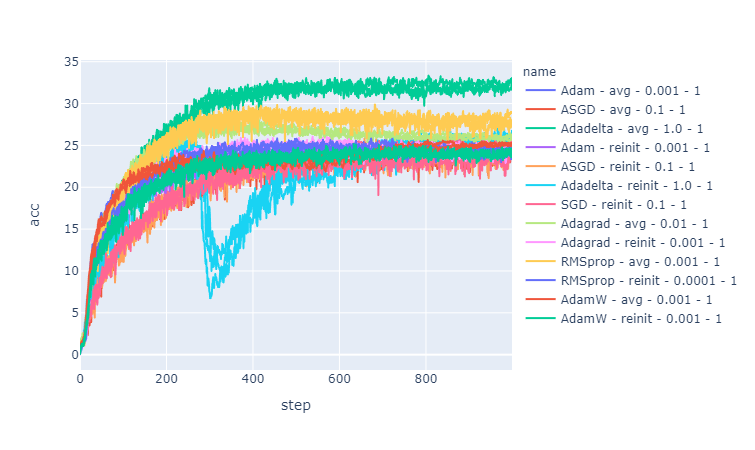

In [10]:
# fig = px.line(df[(df['opt']=='Adadelta')|(df['opt']=='SGD')].sort_values(['key', 'step']), x="step", y="acc", hover_name='key', line_group='key',  color='name') #  &((df['opt']=='Adagrad')|(df['opt']=='SGD'))
fig = px.line(df, x="step", y="acc", hover_name='key', line_group='key',  color='name') #  &((df['opt']=='Adagrad')|(df['opt']=='SGD'))
fig.show()
# fig.write_image('figure.png')

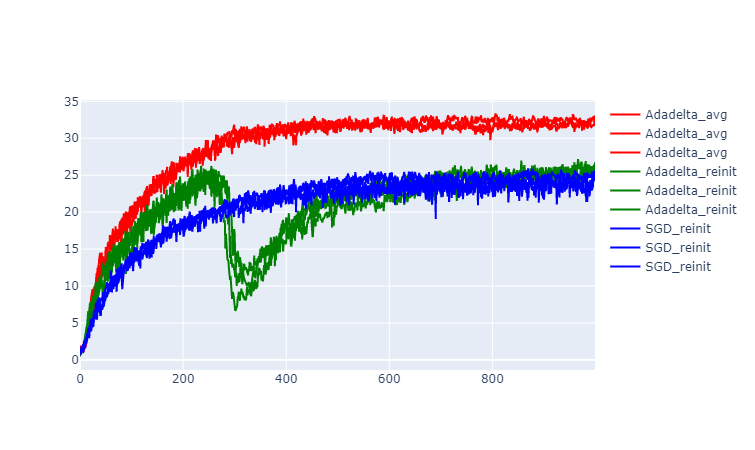

In [9]:
def plot(fig, opt_, opt_strat_, color):
    accs = []
    for exp in exps:
        opt = exp.get_parameters_summary('OPT')['valueMax']
        opt_strat = exp.get_parameters_summary('OPT_STRATEGY')['valueMax']
        if (opt == opt_) and (opt_strat == opt_strat_):
            step, acc = get_acc(exp)
            accs.append(acc)
#     accs = np.array(accs)
            fig.add_trace(go.Scatter(y=acc, name=f"{opt_}_{opt_strat_}", line=dict(color=color))) #, color=color))

fig = go.Figure()
plot(fig, 'Adadelta', 'avg', 'red')
plot(fig, 'Adadelta', 'reinit', 'green')
plot(fig, 'SGD', 'reinit', 'blue')
fig.show()
